In [1]:
pip install torch torchvision

In [2]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.5 MB/s eta 0:00:00


In [3]:
!pip install matplotlib

In [5]:

from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/pytorch'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['Bayesian.ipynb', 'CRL_moon.ipynb', 'Cifar_baseline.ipynb', 'DAC+Dropout_incomplete.ipynb', 'DAC+Temp.ipynb', 'DAC+Temp_Cifar.ipynb', 'Dropout.ipynb', 'FocalLoss.ipynb', 'LabelSmoothing.ipynb', 'Mixup.ipynb', 'ResNet.ipynb', '__init__.py', '__pycache__', 'baseline.ipynb', 'data', 'model', 'py_code', 'result_auroc_OD.json', 'result_auroc_OD_CRL.json', 'result_auroc_OD_LS.json', 'result_auroc_OD_baseline.json', 'result_auroc_OD_dropout.json', 'result_auroc_OD_mixup.json', 'results_DAC_temp.json', 'results_DAC_temp_cifar.json', 'results_DAC_temp_swin.json', 'results_Dropout.json', 'results_Dropout_swin.json', 'results_ECE.json', 'results_ECE_CRL.json', 'results_ECE_LS.json', 'results_ECE_OD.json', 'results_ECE_OD_CRL.json', 'results_ECE_OD_LS.json', 'results_ECE_OD_baseline.json', 'results_ECE_OD_dropout.json', 'results_ECE_OD_mixup.json', 'results_ECE_baseline.json', 'results_ECE_cifar_baseline.json', 'results_ECE_cifar_baseline_OD.json', 'results_ECE_cifar_da

In [6]:
import numpy as np
import os
import json
import random
from PIL import Image
import xml.etree.ElementTree as ET
import pandas as pd


def fsw_labels_to_csv():
    annotations = []
    src_path = "data/raw/hx_fsw/images/"
    for seam_nr in range(1, 115):
        for ann_file in os.listdir(f"{src_path}{seam_nr}/annotations"):
            tree = ET.parse(f"{src_path}{seam_nr}/annotations/{ann_file}")
            item = {}
            for child in tree.getroot():
                item[child.tag] = child.text
            item["img_path"] = f"{src_path}{seam_nr}/cutouts/"+item["filename"]
            item["seam_nr"] = seam_nr  # This adds the seam_nr value to each annotation item
            item.setdefault('temp_label', None)
            item.setdefault('grat_label', None)
            item.setdefault('inner_label', None)
            annotations.append(item)


    df = pd.DataFrame(annotations)
    df.to_csv("data/raw/hx_fsw/annotations.csv", sep=";")


def fsw_make_annotations():
    def df_to_list(df):
        data = [{"img_path": x.replace("../", ""), "seam_nr": y, "Group": m, "labels": (z1, z2, z3)}
            for x, y, z1, z2, z3 , m in zip(df['img_path'], df["Weld Seam Nr."], df['temp_label'], df['grat_label'], df['inner_label'], df['Group'])]
        return data

    df = pd.read_csv("data/raw/hx_fsw/annotations.csv", sep=";")
    all_data = df_to_list(df)

    # Filter out data from groups 1, 2, and 3 for cross-validation
    filtered_data = [d for d in all_data if d['Group'] in [1, 2, 3]]
    # OD data for model evaluation
    OD_data = [d for d in all_data if d['Group'] == 6]

    # Shuffle filtered_data
    random.shuffle(filtered_data)
    # Set the number of splits for cross-validation
    num_splits = 5
    split_size = len(filtered_data) // num_splits

    cv_anns = {}

    for split in range(num_splits):
        # Create train, validation, and test splits
        start = split * split_size
        end = start + split_size
        test_data = filtered_data[start:end]

        train_data = filtered_data[:start] + filtered_data[end:]
        train_end = len(train_data) - len(train_data) // 3
        train_data, val_data = train_data[:train_end], train_data[train_end:]

        cv_anns[split + 1] = {
            "train": train_data,
            "val": val_data,
            "test": test_data,
            "ODdata": OD_data
        }

        print(f"Split {split + 1}: Train = {len(train_data)}, Val = {len(val_data)}, Test = {len(test_data)}, OD = {len(OD_data)}")

    # Write the cross-validation annotations to a file
    with open("data/raw/hx_fsw/cv_annotations.json", "w") as file:
        file.write(json.dumps(cv_anns, indent=4))


In [7]:
fsw_make_annotations()

Split 1: Train = 1480, Val = 740, Test = 554, OD = 1522
Split 2: Train = 1480, Val = 740, Test = 554, OD = 1522
Split 3: Train = 1480, Val = 740, Test = 554, OD = 1522
Split 4: Train = 1480, Val = 740, Test = 554, OD = 1522
Split 5: Train = 1480, Val = 740, Test = 554, OD = 1522


In [8]:
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image


class FSWDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        """
        Overwrites the methods of the pytorch dataset class and defines
        how to return an image and a label

        Args:
            paths: list with image paths
            labels: list with labels
            transform: None or torchvision transforms to apply to image
        """

        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # load specific sample
        img = Image.open(self.paths[idx])
        label = self.labels[idx]

        label = torch.tensor(label, dtype=torch.long)

        # apply transforms
        if self.transform is not None:
            img = self.transform(img)

        return img, label


class AddNoiseToTensor(object):
    def __init__(self, p, alpha):
        """
        implements the __call__ method of a torchvision transform operation

        Args:
            p: probability with which the transform should be applied
            alpha: scaling factor for the normal distributed noise
        """
        self.p = p
        self.a = alpha

    def __call__(self, x):

        # tip: use pytorch for random operations, since it handles management of random seeds in
        # workers of dataloader correctly. Numpy for example doesn't, which results in identical samples
        if torch.rand(1) < self.p:
            # add noise from normal distribution to tensor with a given probability
            return x + torch.randn_like(x) * self.a
        return x


class AdjustBrightnessOfTensor(object):
    def __init__(self, p, alpha):
        """
        implements the __call__ method of a torchvision transform operation

        Args:
            p: probability with which the transform should be applied
            alpha: scaling factor for the uniform distributed noise
        """
        self.p = p
        self.a = alpha

    def __call__(self, x):
        if torch.rand(1) < self.p:
            # add brightness value from uniform distribution to tensor with a given probability
            x = x + (torch.rand(1) - 0.5) * self.a
            x = torch.where(x < 1., x, 1.)
            x = torch.where(x > 0., x, 0.)
        return x


In [9]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
for cv_i in [str(x) for x in range(1, 5)]:
    # get paths and labels
    label_i = 1  # (grat)
    num_classes = 2  # (grat)
    with open(f"data/raw/hx_fsw/cv_annotations.json") as file:
        data = json.load(file)

    vl_paths = [sample["img_path"] for sample in data[cv_i]["val"]]
    vl_labels = [sample["labels"][label_i] for sample in data[cv_i]["val"]]
    ts_paths = [sample["img_path"] for sample in data[cv_i]["test"]]
    ts_labels = [sample["labels"][label_i] for sample in data[cv_i]["test"]]
    tr_paths = [sample["img_path"] for sample in data[cv_i]["train"]]
    tr_labels = [sample["labels"][label_i] for sample in data[cv_i]["train"]]

    # prep for the OD data
    OD_paths = [sample["img_path"] for sample in data[cv_i]["ODdata"]]
    OD_labels = [sample["labels"][label_i] for sample in data[cv_i]["ODdata"]]




tr_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Add this line
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    AddNoiseToTensor(p=0.5, alpha=0.1),
])

vl_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Add this line
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# build datasets and dataloaders
train_dataset = FSWDataset(paths=tr_paths, labels=tr_labels, transform=tr_transform)
test_dataset = FSWDataset(paths=ts_paths, labels=ts_labels, transform=vl_transform)
val_dataset = FSWDataset(paths=vl_paths, labels=vl_labels, transform=vl_transform)
OD_dataset = FSWDataset(paths=OD_paths, labels=OD_labels, transform=vl_transform)

# Model loading and overriding
The last fully connected layer of the original model is replaced with a new one containing a dropout layer (for regularization) followed by a linear layer for a binary classification task.
The forward method of this class is overridden to modify the standard forward pass of the ResNet model. Here, the model processes the input through all its layers up to the average pooling layer. The output tensor is then flattened to obtain feature representations (features), and these features are further processed by the fully connected layer (self.fc) to obtain the final output.
The model now returns both the final output and the features.
An instance of the ModifiedResNet model is created using ResNet50's configuration (i.e., using the Bottleneck block and [3, 4, 6, 3] layers, which corresponds to ResNet50). The number of output classes is set to 2, which indicates binary classification.
Again, as with the initial ResNet50 model, the final fully connected layer is replaced with a dropout layer followed by a linear layer

In [10]:
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import random

# Add a Dropout layer followed by the final Linear layer
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader= DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
OD_loader= DataLoader(OD_dataset, batch_size=64, shuffle=False, num_workers=4)

In [11]:
import torch
import torchvision.models as models
model = models.resnet50(pretrained=True)
# Add Dropout and Final Linear Layer to the model's fc
num_classes = 2
model.fc = nn.Sequential(
    nn.Dropout(0.5), # 50% dropout rate
    nn.Linear(model.fc.in_features, num_classes)
)
#This setup means that during training, the dropout layer will randomly zero out (with a probability of 50%)

# If you want to initialize with pretrained weights:
state_dict = models.resnet50(pretrained=True).state_dict()
del state_dict["fc.weight"]
del state_dict["fc.bias"]
model.load_state_dict(state_dict, strict=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


_IncompatibleKeys(missing_keys=['fc.1.weight', 'fc.1.bias'], unexpected_keys=[])

This new class aims to modify the provided original_model (in this case, a ResNet model) to not only return the final output (class probabilities) but also the feature representations from the layer before the final fully connected (FC) layer.

The feature extraction part (named self.features) is created by taking all layers from the original_model except the last one (the final FC layer). This is achieved using the list(original_model.children())[:-1] command. The purpose is to get the feature maps before they are flattened and passed through the final FC layer.
The final FC layer (self.fc) is separately stored, as it will be used to produce the final output.

The forward method takes an input tensor x and passes it through the feature extraction layers.
These feature maps are then flattened and passed through the final FC layer to get the model's output.
The function returns both the final output and the feature maps, providing dual functionality: standard prediction and feature extraction.


In [12]:
pip install tqdm tensorboard

In [13]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm  # for a nice progress bar
import matplotlib.pyplot as plt
train_losses = []
val_accuracies = []

# Parameters
num_epochs = 30
learning_rate = 1e-6

# Using CUDA if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0.0

    for i, (inputs, labels) in enumerate(tqdm(train_loader)):

        inputs, labels = inputs.to(device), labels.to(device)

        # Getting outputs and features
        outputs = model(inputs)
        # Use the outputs for loss calculation
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {total_loss/len(train_loader):.4f}")


    # Validation loop with MC Dropout
    num_forward_passes = 10  # Number of forward passes to average over
    model.train()  # Keep dropout active
    val_correct = 0
    val_total = 0
    val_accuracies = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs_list = []

            for _ in range(num_forward_passes):
                outputs = model(inputs)  # Get model outputs
                outputs_list.append(outputs)

            # Average the outputs across the multiple forward passes
            outputs_mean = torch.mean(torch.stack(outputs_list), dim=0)

            # Calculate accuracy based on the averaged outputs
            _, predicted = torch.max(outputs_mean, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        val_accuracies.append(val_accuracy)
        print(f"Validation Accuracy with MC Dropout: {val_accuracy:.2f}%")

print("Finished Training")

  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 1/30] Loss: 0.7164
Validation Accuracy with MC Dropout: 61.22%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 2/30] Loss: 0.6802
Validation Accuracy with MC Dropout: 65.41%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 3/30] Loss: 0.6365
Validation Accuracy with MC Dropout: 68.78%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 4/30] Loss: 0.6284
Validation Accuracy with MC Dropout: 73.11%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 5/30] Loss: 0.6221
Validation Accuracy with MC Dropout: 74.46%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 6/30] Loss: 0.5829
Validation Accuracy with MC Dropout: 77.30%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 7/30] Loss: 0.5635
Validation Accuracy with MC Dropout: 78.38%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 8/30] Loss: 0.5355
Validation Accuracy with MC Dropout: 81.08%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 9/30] Loss: 0.5150
Validation Accuracy with MC Dropout: 82.03%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 10/30] Loss: 0.5026
Validation Accuracy with MC Dropout: 81.22%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 11/30] Loss: 0.4699
Validation Accuracy with MC Dropout: 82.57%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 12/30] Loss: 0.4751
Validation Accuracy with MC Dropout: 83.65%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 13/30] Loss: 0.4421
Validation Accuracy with MC Dropout: 84.19%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 14/30] Loss: 0.4229
Validation Accuracy with MC Dropout: 84.46%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 15/30] Loss: 0.4138
Validation Accuracy with MC Dropout: 85.68%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 16/30] Loss: 0.4013
Validation Accuracy with MC Dropout: 86.35%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 17/30] Loss: 0.3977
Validation Accuracy with MC Dropout: 86.08%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 18/30] Loss: 0.3764
Validation Accuracy with MC Dropout: 86.49%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 19/30] Loss: 0.3749
Validation Accuracy with MC Dropout: 87.43%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 20/30] Loss: 0.3572
Validation Accuracy with MC Dropout: 86.89%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 21/30] Loss: 0.3355
Validation Accuracy with MC Dropout: 88.11%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 22/30] Loss: 0.3223
Validation Accuracy with MC Dropout: 87.70%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 23/30] Loss: 0.3167
Validation Accuracy with MC Dropout: 89.19%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 24/30] Loss: 0.3164
Validation Accuracy with MC Dropout: 88.92%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 25/30] Loss: 0.3021
Validation Accuracy with MC Dropout: 88.65%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 26/30] Loss: 0.3098
Validation Accuracy with MC Dropout: 89.59%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 27/30] Loss: 0.2780
Validation Accuracy with MC Dropout: 89.86%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 28/30] Loss: 0.2785
Validation Accuracy with MC Dropout: 90.54%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 29/30] Loss: 0.2602
Validation Accuracy with MC Dropout: 89.59%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 30/30] Loss: 0.2538
Validation Accuracy with MC Dropout: 90.14%
Finished Training


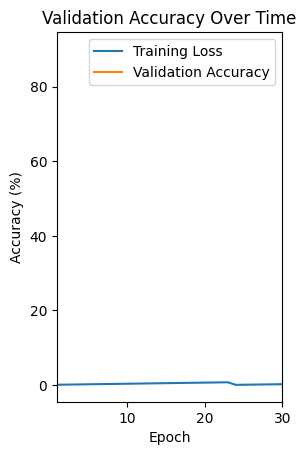

In [14]:
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.xlim(1, num_epochs)  # Set x-axis limits

# Plot validation accuracy
plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Time')
plt.legend()
plt.xlim(1, num_epochs)  # Set x-axis limits

plt.show()


In [15]:
def evaluate(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # We'll also keep track of the loss for the test dataset
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs  = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)  # Predicted class is the max index across the softmax probabilities
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    return accuracy, avg_test_loss

# To use the evaluate function:
accuracy, avg_loss = evaluate(model,test_loader, device) # change the data here to experience concept drift
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Average Test Loss: {avg_loss:.4f}")

Test Accuracy: 92.42%
Average Test Loss: 0.2416


In [16]:
def evaluate(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # We'll also keep track of the loss for the test dataset
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)  # Predicted class is the max index across the softmax probabilities
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    return accuracy, avg_test_loss

# To use the evaluate function:
accuracy, avg_loss = evaluate(model, OD_loader, device) # change the data here to experience concept drift
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Average Test Loss: {avg_loss:.4f}")

Test Accuracy: 77.40%
Average Test Loss: 0.4977


MC dropout as Post Hoc calibration

In [17]:
# Test with dropout calibration
model.train()  # Ensure dropout layers remain active
num_forward_passes=10
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs_list = []

        for _ in range(num_forward_passes):
            outputs = model(inputs)
            outputs_list.append(outputs)

        outputs_mean = torch.mean(torch.stack(outputs_list), dim=0)
        _, predicted = outputs_mean.max(1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy_dropout = 100 * correct_test / total_test
print(f"Test Accuracy with Dropout Calibration: {test_accuracy_dropout:.2f}%")

Test Accuracy with Dropout Calibration: 91.88%


In [18]:
import json
from datetime import datetime

# Sample test result and current datetime
test_result_dropout = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "test_accuracy": test_accuracy_dropout  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_Dropout.json', 'a') as file:
    file.write(json.dumps(test_result_dropout) + '\n')

In [19]:
import torch.nn.functional as F
def compute_ece(probs, labels, n_bins=10):
    """
    Compute the Expected Calibration Error (ECE).

    Args:
        probs: Tensor of predicted probabilities of shape [N, C] where C is number of classes.
        labels: Tensor of true labels of shape [N].
        n_bins: Number of bins to use for ECE computation.

    Returns:
        ece: Expected Calibration Error.
    """

    # Get the predicted confidence values (maximum predicted probability)
    confidences, predictions = probs.max(1)

    # Initialize lists to store true positive counts and total count for each bin
    bin_true_positives = [0 for _ in range(n_bins)]
    bin_total = [0 for _ in range(n_bins)]

    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    for bin_idx in range(n_bins):
        # Indices of items in the current bin
        bin_indices = (confidences > bin_lowers[bin_idx]) & (confidences <= bin_uppers[bin_idx])

        bin_true_positives[bin_idx] += (predictions[bin_indices] == labels[bin_indices]).float().sum().item()
        bin_total[bin_idx] += bin_indices.float().sum().item()

    # Compute bin accuracies and average confidences
    bin_accuracies = [bin_true_positives[i] / bin_total[i] if bin_total[i] > 0 else 0 for i in range(n_bins)]
    bin_avg_confidences = [torch.sum(confidences[(confidences > bin_lowers[i]) & (confidences <= bin_uppers[i])]).item() / bin_total[i] if bin_total[i] > 0 else 0 for i in range(n_bins)]

    ece = sum([bin_total[i] / float(probs.size(0)) * abs(bin_avg_confidences[i] - bin_accuracies[i]) for i in range(n_bins)])

    return ece

# After your training/testing loops
# initialization for porbs and truelabels
probs = torch.tensor([]).to(device)
true_labels = torch.tensor([]).to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Ensure that outputs is a 2D tensor
        if outputs.ndim == 1:
            outputs = outputs.unsqueeze(0)  # Add batch dimension if missing
        if outputs.ndim != 2:
            raise ValueError("Output from the model must be a 2D tensor")

        actual_outputs = outputs  # Assuming outputs is already the logits

        # Apply softmax on the correct dimension
        output_probs = F.softmax(actual_outputs, dim=1)
        probs = torch.cat([probs, output_probs], dim=0)
        true_labels = torch.cat([true_labels, labels], dim=0)

ece = compute_ece(probs, true_labels)
print(f"Expected Calibration Error (ECE): {ece:.4f}")


Expected Calibration Error (ECE): 0.0918


In [20]:
# Sample test result and current datetime
result_ece = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "ECE": ece  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_ECE_dropout.json', 'a') as file:
    file.write(json.dumps(result_ece) + '\n')


In [21]:
import numpy as np
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

model.eval()
correctness = []
predicted_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Extract the actual output logits from the tuple
        logits = outputs[0] if isinstance(outputs, tuple) else outputs

        # Get probabilities (assuming binary classification)
        probs = F.softmax(logits, dim=1)[:, 1]

        # Get predictions
        preds = probs > 0.5

        # Store probabilities and correctness
        predicted_probs.extend(probs.cpu().numpy())
        correctness.extend(labels.cpu().numpy())

# Calculate AUROC
auroc = roc_auc_score(correctness, predicted_probs)
print(f"AUROC: {auroc:.4f}")


AUROC: 0.9796


In [22]:
# Sample test result and current datetime
result_auroc = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "auroc": auroc  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_auroc_dropout.json', 'a') as file:
    file.write(json.dumps(result_auroc) + '\n')
    # bear in mind that the above 2 code blocks are for the ID acc and ECE, the below blocks are for the OD

The Above code are all for the ID dada,
Below are for the OD data for calculating the ECE for data with concept drift

In [23]:
import torch.nn.functional as F

# After your training/testing loops
probs = torch.tensor([]).to(device)
true_labels = torch.tensor([]).to(device)

model.eval()
with torch.no_grad():
    for inputs, labels in OD_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Ensure that outputs is a 2D tensor
        if outputs.ndim == 1:
            outputs = outputs.unsqueeze(0)  # Add batch dimension if missing
        if outputs.ndim != 2:
            raise ValueError("Output from the model must be a 2D tensor")

        actual_outputs = outputs  # Assuming outputs is already the logits

        # Apply softmax on the correct dimension
        output_probs = F.softmax(actual_outputs, dim=1)
        probs = torch.cat([probs, output_probs], dim=0)
        true_labels = torch.cat([true_labels, labels], dim=0)
ece_od = compute_ece(probs, true_labels)
print(f"Expected Calibration Error (ECE): {ece_od:.4f}")


Expected Calibration Error (ECE): 0.1068


In [24]:
# Sample test result and current datetime
result_ece_od = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "ECE": ece_od  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_ECE_OD_dropout.json', 'a') as file:
    file.write(json.dumps(result_ece_od) + '\n')

In [25]:
import numpy as np
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

model.eval()
correctness = []
predicted_probs = []

with torch.no_grad():
    for inputs, labels in OD_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Extract the actual output logits from the tuple
        logits = outputs[0] if isinstance(outputs, tuple) else outputs

        # Get probabilities (assuming binary classification)
        probs = F.softmax(logits, dim=1)[:, 1]

        # Get predictions
        preds = probs > 0.5

        # Store probabilities and correctness
        predicted_probs.extend(probs.cpu().numpy())
        correctness.extend(labels.cpu().numpy())

# Calculate AUROC
auroc_OD = roc_auc_score(correctness, predicted_probs)
print(f"AUROC: {auroc:.4f}")


AUROC: 0.9796


In [26]:
# Sample test result and current datetime
result_auroc_OD = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "auroc": auroc_OD  # Example accuracy value
}

# Saving the result to 'results.json'
with open('result_auroc_OD_dropout.json', 'a') as file:
    file.write(json.dumps(result_auroc_OD) + '\n')
    # bear in mind that the above 2 code blocks are for the ID acc and ECE, the below blocks are for the OD